# SSVEP-EEG DATA COLLECTION USING EMOTIV EPOC

Dataset: https://ieee-dataport.org/documents/ssvep-eeg-data-collection-using-emotiv-epoc#files


- 10 visual stimuli frequencies (7, 9, 11 and 13)
- 2 electrodes (LO, RO) 
- 128 samples per second, Stimuli was provided for 3.5s

Asanza, V., Avilés-Mendoza, K., Trivino-Gonzalez, H., Rosales-Uribe, F., Torres-Brunes, J., Loayza, F. R., ... & Tinoco-Egas, R. (2021). SSVEP-EEG signal classification based on emotiv EPOC BCI and raspberry Pi. IFAC-PapersOnLine, 54(15), 388-393.
https://www.sciencedirect.com/science/article/pii/S240589632101692X

### 1. Data Visualization

In [2]:
import pandas as pd

DATASET = '../Dataset/3_Filtered_Data/'
stimuli = ['7Hz', '9Hz', '11Hz', '13Hz', 'Baseline']

for s in stimuli:
    stim = pd.read_csv(DATASET + s + '/muestra4.csv')
    #stim[['EEG.O1', 'EEG.O2']].plot(subplots=True)

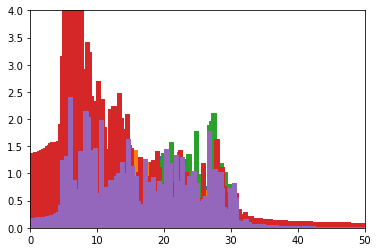

In [3]:
# FFT
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

Fs = 128
T = 1/Fs

for s in stimuli:
    stim = pd.read_csv(DATASET + s + '/muestra11.csv')
    #stim[['EEG.O1', 'EEG.O2']].plot(subplots=True)

    signal = stim['EEG.O1'].to_numpy()

    s_fft = np.fft.fft(signal)
    amplitude = abs(s_fft)*(2/len(s_fft))
    frequency = np.fft.fftfreq(len(s_fft), T)

    plt.xlim(0, 50)
    plt.ylim(0, 4)
    plt.bar(frequency, amplitude)
    #plt.show()

### 2. Classification Preprocessing

#### 1) Feature Extraction

For feature extraction the algorithm 1 was developed to extract 21 features from the training, validation and test sets: Mean, Mean - weight I, Mean - weight II, Log Detector, Median, Variance, Mean absolute difference, Mean frecuency, Peak frecuency, Variance central frecuency, Maximum PSD, Amplitude Histogram (10 ranges).

Then, in both cases the training set features were normalized using sklearn’s MinMaxScaler function, as shown in equation 1. Finally, the validation and test sets were normalized with the Min and Max values obtained from the training set.

In [3]:
# Feature Extraction
import csv, os, math
import pandas as pd
import numpy as np
import scipy.signal

DATASET = '../Dataset/3_Filtered_Data/'
stimuli = ['7Hz', '9Hz', '11Hz', '13Hz', 'Baseline']
channel = ['EEG.O1', 'EEG.O2']

stimuli = ['7Hz']


# Read All File Lists
def getFileName(path_dir):
    file_list = os.listdir(path_dir)
    file_list.sort()
    dataList = []

    for f in file_list:
        if f.find('.csv') != -1:
            dataList.append(f)

    return dataList


def HistogramaAmplitud(data):
    return [0]


# Extract Features
for s in stimuli:
    fList = getFileName(DATASET + s)

    for f in fList:
        trial = pd.read_csv(DATASET + s + '/' + f)
        trialFeature = []

        for c in channel:

            # Mean
            mean = trial[c].mean()

            # Mean - weight I
            res = []
            for i in range(len(trial[c])):
                i += 1
                if i <= 0.75*len(trial[c]) and i >= 0.25*len(trial[c]):
                    w = 1
                else:
                    w = 0.5
                res.append(abs(trial.iloc[i-1][c])*w)
            mean1 = np.array(res).mean()

            # Mean - weight II
            res = []
            for i in range(len(trial[c])):
                i += 1
                if i <= 0.75*len(trial[c]) and i >= 0.25*len(trial[c]):
                    w = 1
                elif i < 0.25*len(trial[c]) :
                    w = 4*i/len(trial[c])
                else:
                    w = 4*(len(trial[c])-i)/len(trial[c])
                res.append(abs(trial.iloc[i-1][c])*w)
            mean2 = np.array(res).mean()

            # Log Detector
            logDetector = math.exp(np.log(abs(trial[c]).to_frame()).mean()[c])

            # Median
            median = trial[c].median()

            # Variance
            variance = trial[c].var()

            # Mean absolute difference
            mad = np.median(np.absolute(trial[c] - np.median(trial[c], axis=0)), axis=0)

            # FFT
            f, sp = scipy.signal.periodogram(trial[c], 128)
            frequency = f[30:60]
            spectrum = sp[30:60]

            # Mean frecuency
            f, sp = scipy.signal.periodogram(trial[c], 128)
            meanFreq = ((f * sp).sum())/(sp.sum())

            # Peak frecuency
            frequency_peak_indice = np.argmax(spectrum)
            peakFreq = frequency[frequency_peak_indice]
            
            # Variance central frecuency
            frequency_avg = np.mean(f)
            vcf = np.sum(sp * pow(f- frequency_avg,2))/frequency_avg
            
            # Maximum PSD
            maxPSD = np.max(spectrum)
            
            # Amplitude Histogram (10 ranges)
            ampHist = HistogramaAmplitud(trial[c])

            channelFeature = [mean, mean1, mean2, logDetector, median, variance, mad, meanFreq, peakFreq, vcf, maxPSD].extend(ampHist)
            trialFeature.append(channelFeature)

        trialFeature = np.array(trialFeature)
        #np.save('../Dataset/4_Feature Extracted Data/' + s + '_' + f, trialFeature)


KeyboardInterrupt: 